In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_palette('colorblind')

In [51]:
stats = xr.open_dataset('openfast_monveer_llj_classC_sim_stats.nc')
wind = xr.open_dataset('data/processed_inflows.nc')

In [55]:
mean_shear_LLJ = wind['mean_shear_LLJ'].rolling(t=6).mean().isel(t=slice(5,None,6))
mean_shear_MON = wind['mean_shear_MON'].rolling(t=6).mean().isel(t=slice(5,None,6))
mean_shear = xr.DataArray(
    data=[mean_shear_LLJ.data, mean_shear_MON.data],
    dims=['cond','date','t_sec'],
    coords=dict(
        t_sec=stats['t_sec'],
        cond=stats['cond'],
        date=stats['date']
    ),
    attrs=dict(units='[1/s]')
)
z_max = xr.DataArray(
    data=wind['z_max_LLJ'].rolling(t=6).mean().isel(t=slice(5,None,6)),
    dims=['date','t_sec'],
    coords=dict(
        t_sec=stats['t_sec'],
        date=stats['date']
    ),
    attrs=dict(units='[m]')
)
mean_shear = mean_shear.expand_dims(dim={"turb_seed": 6})
z_max = z_max.expand_dims(dim={"turb_seed": 6})
mean_shear = mean_shear.transpose('date','cond','turb_seed','t_sec')
stats['mean_shear'] = mean_shear
stats['z_max'] = z_max

In [56]:
stats['MeanHHWindVel'] = stats['MeanWind3VelX']
stats['StdevHHWindVel'] = stats['StdevWind3VelX']

In [57]:
stats

<xarray.Dataset>
Dimensions:         (turb_seed: 6, t_sec: 18, date: 3, cond: 2)
Coordinates:
  * turb_seed       (turb_seed) int64 0 1 2 3 4 5
  * t_sec           (t_sec) int64 0 3600 7200 10800 ... 50400 54000 57600 61200
  * date            (date) object 'April5' 'June3' 'May15'
  * cond            (cond) object 'LLJ' 'MS+veer'
Data variables: (12/128)
    MeanGenPwr      (date, cond, turb_seed, t_sec) float64 ...
    MeanGenTq       (date, cond, turb_seed, t_sec) float64 ...
    MeanGenSpeed    (date, cond, turb_seed, t_sec) float64 ...
    MeanRtSpeed     (date, cond, turb_seed, t_sec) float64 ...
    MeanBldPitch1   (date, cond, turb_seed, t_sec) float64 ...
    MeanRtTSR       (date, cond, turb_seed, t_sec) float64 ...
    ...              ...
    MaxWind4VelY    (date, cond, turb_seed, t_sec) float64 ...
    MaxWind4VelZ    (date, cond, turb_seed, t_sec) float64 ...
    mean_shear      (date, cond, turb_seed, t_sec) float64 0.0003576 ... 0.00...
    MeanHHWindVel   (date, cond, turb_seed, t_sec) float64 ...
    StdevHHWindVel  (date, cond, turb_seed, t_sec) float64 ...
    z_max           (turb_seed, date, t_sec) float64 70.0 70.0 63.33 ... 0.0 0.0

In [43]:
#t_hr = stats.coords['t_sec'] / 3600.
t_hr = (stats.coords['t_sec'] / 3600.) + 0.5 # shift to center of interval
inflows = [cond.item() for cond in stats.coords['cond']]

In [7]:
def plot_mean_stdev(date,channel,name):
    """Plot mean and standard deviation on subplots
    
    Solid line is the median, whereas the shaded region indicates the extrema
    of the 6 turbulence realizations (seeds).
    """
    fig,axs = plt.subplots(nrows=2,sharex=True)
    caseday = stats.sel(date=date)
    for ax,qty in zip(axs,['Mean','Stdev']):
        for cond in inflows:
            ds = caseday[f'{qty}{channel}'].sel(cond=cond)
            line, = ax.plot(t_hr, ds.median('turb_seed'), label=cond)
            color = line.get_color()
            ax.fill_between(t_hr, ds.min('turb_seed'), ds.max('turb_seed'), color=color, alpha=0.2)
        ax.set_ylabel(f'{qty}\n{name}\n[{ds.attrs["units"]}]')
        #ax.set_title(qty)
    axs[0].set_title(f'{date} {name}')
    axs[0].legend(loc='upper left',bbox_to_anchor=(1,1))
    axs[-1].set_xticks(range(0,20,2))
    axs[-1].set_xlabel('time [h]')
    return fig,axs

In [8]:
def plot_mean_stdev(axs,date,channel,name):
    """Plot mean and standard deviation on subplots
    
    Solid line is the median, whereas the shaded region indicates the extrema
    of the 6 turbulence realizations (seeds).
    """
    caseday = stats.sel(date=date)
    for ax,qty in zip(axs,['Mean','Stdev']):
        for cond in inflows:
            ds = caseday[f'{qty}{channel}'].sel(cond=cond)
            line, = ax.plot(t_hr, ds.median('turb_seed'), label=cond)
            color = line.get_color()
            ax.fill_between(t_hr, ds.min('turb_seed'), ds.max('turb_seed'), color=color, alpha=0.2)
        ax.set_ylabel(f'{qty}\n{name}\n[{ds.attrs["units"]}]')

# Check case study day

In [9]:
date = 'May15'
#date = 'April5'
#date = 'June3'

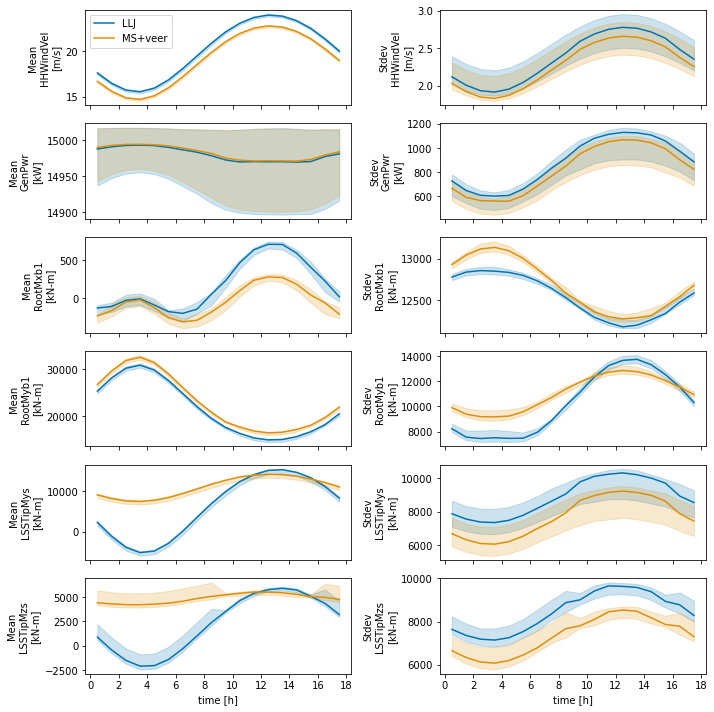

In [12]:
(fig, ax) = plt.subplots(6, 2, sharex=True, figsize=(10,10))
qtys = ['HHWindVel','GenPwr','RootMxb1','RootMyb1','LSSTipMys','LSSTipMzs']
for (i, qty) in enumerate(qtys):
    plot_mean_stdev(ax[i],date,qty,qty)
ax[0][0].legend(loc='upper left')
ax[-1][0].set_xticks(range(0,20,2))
ax[-1][0].set_xlabel('time [h]')
ax[-1][1].set_xlabel('time [h]')
plt.tight_layout()
plt.savefig('figures/fig3a_May15_results.pdf')

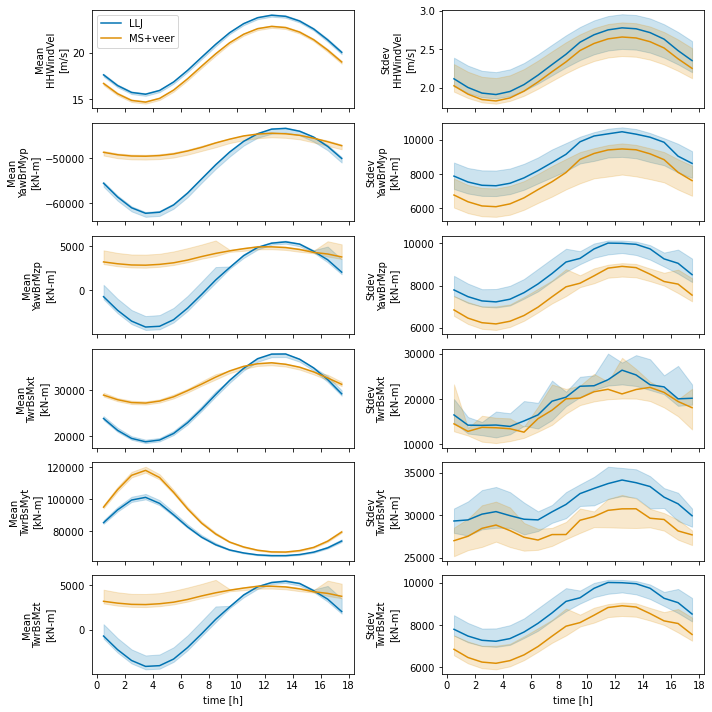

In [13]:
(fig, ax) = plt.subplots(6, 2, sharex=True, figsize=(10,10))
qtys = ['HHWindVel','YawBrMyp','YawBrMzp','TwrBsMxt','TwrBsMyt','TwrBsMzt']
for (i, qty) in enumerate(qtys):
    plot_mean_stdev(ax[i],date,qty,qty)
ax[0][0].legend(loc='upper left')
ax[-1][0].set_xticks(range(0,20,2))
ax[-1][0].set_xlabel('time [h]')
ax[-1][1].set_xlabel('time [h]')
plt.tight_layout()
plt.savefig('figures/fig3b_May15_results.pdf')

## Rotor quantities

In [10]:
fig,axs = plot_mean_stdev(date,'GenPwr','Generator Power')

TypeError: plot_mean_stdev() missing 1 required positional argument: 'name'

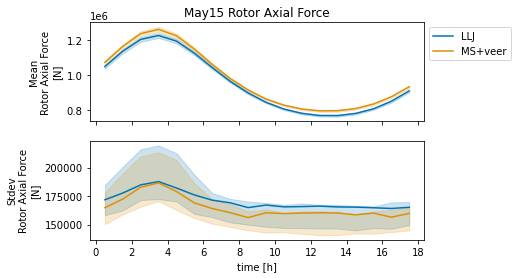

In [ ]:
fig,axs = plot_mean_stdev(date,'RtFldFxh','Rotor Axial Force')

## Blade quantities

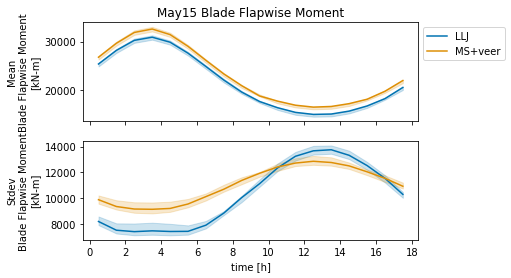

In [ ]:
fig,axs = plot_mean_stdev(date,'RootMyb1','Blade Flapwise Moment')

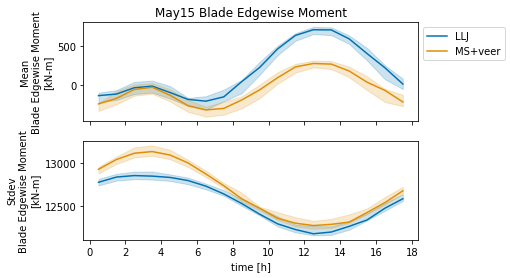

In [ ]:
fig,axs = plot_mean_stdev(date,'RootMxb1','Blade Edgewise Moment')

## Tower quantities

Text(0.5, 1.0, 'May15 Tower-Top Pitching Moment')

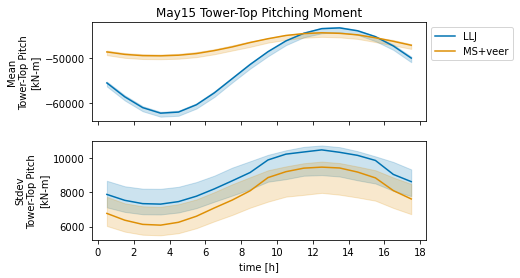

In [ ]:
fig,axs = plot_mean_stdev(date,'YawBrMyp','Tower-Top Pitch')
axs[0].set_title(f'{date} Tower-Top Pitching Moment')

Text(0.5, 1.0, 'May15 Tower-Top Yawing Moment')

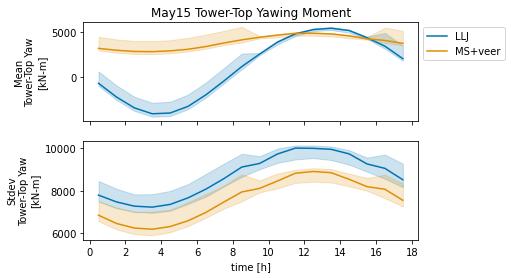

In [ ]:
fig,axs = plot_mean_stdev(date,'YawBrMzp','Tower-Top Yaw')
axs[0].set_title(f'{date} Tower-Top Yawing Moment')

In [ ]:
# approx equal to Tower-Top Yaw
#fig,axs = plot_mean_stdev(date,'TwrBsMzt','Tower-Base Torsion')

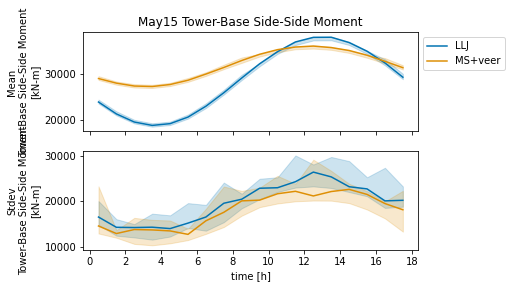

In [ ]:
fig,axs = plot_mean_stdev(date,'TwrBsMxt','Tower-Base Side-Side Moment')

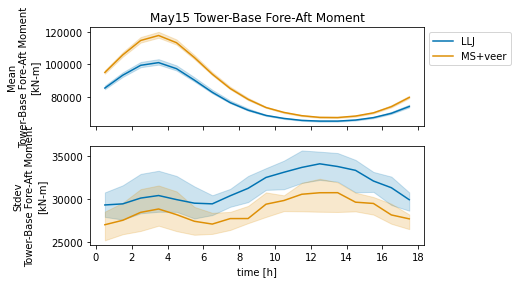

In [ ]:
fig,axs = plot_mean_stdev(date,'TwrBsMyt','Tower-Base Fore-Aft Moment')

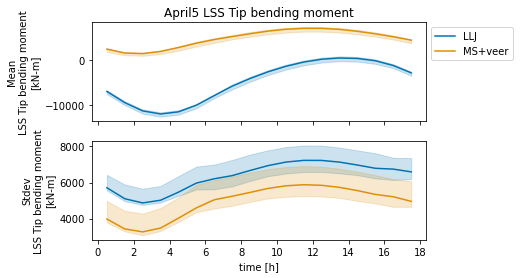

In [ ]:
fig,axs = plot_mean_stdev(date,'LSSTipMys','LSS Tip bending moment')

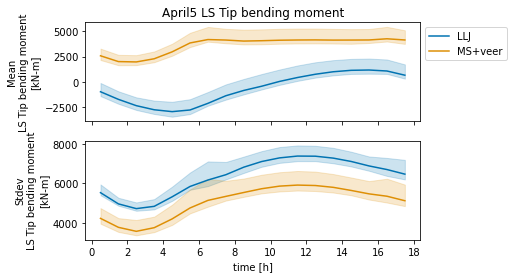

In [ ]:
fig,axs = plot_mean_stdev(date,'LSSTipMzs','LS Tip bending moment')

# compare all 3 case days for specific quantities

In [14]:
#dates = stats.coords['date'].values
dates = {
    'April5': 'April 5: moderate wind, narrow jet at HH',
    'May15': 'May 15: high wind, narrow jet above HH',
    'June3': 'June 3: low wind, broad jet',
}

In [15]:
def plot_comparison(channel,name):
    """Plot comparison of specified channel for all 3 case days
    
    Solid line is the median, whereas the shaded region indicates the extrema
    of the 6 turbulence realizations (seeds).
    """
    fig,axs = plt.subplots(nrows=len(dates),sharex=True)
    for ax,(date,desc) in zip(axs, dates.items()):
        for cond in inflows:
            ds = stats[f'{channel}'].sel(date=date,cond=cond)
            line, = ax.plot(t_hr, ds.median('turb_seed'), label=cond)
            color = line.get_color()
            ax.fill_between(t_hr, ds.min('turb_seed'), ds.max('turb_seed'), color=color, alpha=0.2)
        #ax.set_ylabel(f'{name}\n[{ds.attrs["units"]}]')
        ax.set_title(desc)
    axs[0].legend(loc='upper left',bbox_to_anchor=(1,1))
    axs[len(dates)//2].set_ylabel(f'{name}\n[{ds.attrs["units"]}]')
    axs[-1].set_xticks(range(0,20,2))
    axs[-1].set_xlabel('time [h]')
    fig.tight_layout()
    return fig,axs

In [44]:
def plot_comparison(subfig,channel,name,ylims):
    """Plot comparison of specified channel for all 3 case days
    
    Solid line is the median, whereas the shaded region indicates the extrema
    of the 6 turbulence realizations (seeds).
    """
    axs = subfig.subplots(nrows=len(dates),sharex=True)
    for ax,(date,desc) in zip(axs, dates.items()):
        for cond in inflows:
            ds = stats[f'Mean{channel}'].sel(date=date,cond=cond)
            ds2 = stats[f'Stdev{channel}'].sel(date=date,cond=cond)
            line, = ax.plot(t_hr, ds.median('turb_seed'), label=f'{cond}')
            color = line.get_color()
            ax.fill_between(t_hr, ds.median('turb_seed') - ds2.median('turb_seed'), ds.median('turb_seed') + ds2.median('turb_seed'), color=color, alpha=0.2)
            #ax.plot(t_hr, ds.median('turb_seed'), label=f'{cond} Stdev', color=color, linestyle='--')
        #ax.set_ylabel(f'{name}\n[{ds.attrs["units"]}]')
        ax.set_title(desc)
        ax.set_ylim(ylims)
    axs[0].legend(loc='upper left')
    axs[len(dates)//2].set_ylabel(f'{name}\n[{ds.attrs["units"]}]')
    axs[-1].set_xticks(range(0,20,2))
    axs[-1].set_xlabel('time [h]')
    return fig,axs

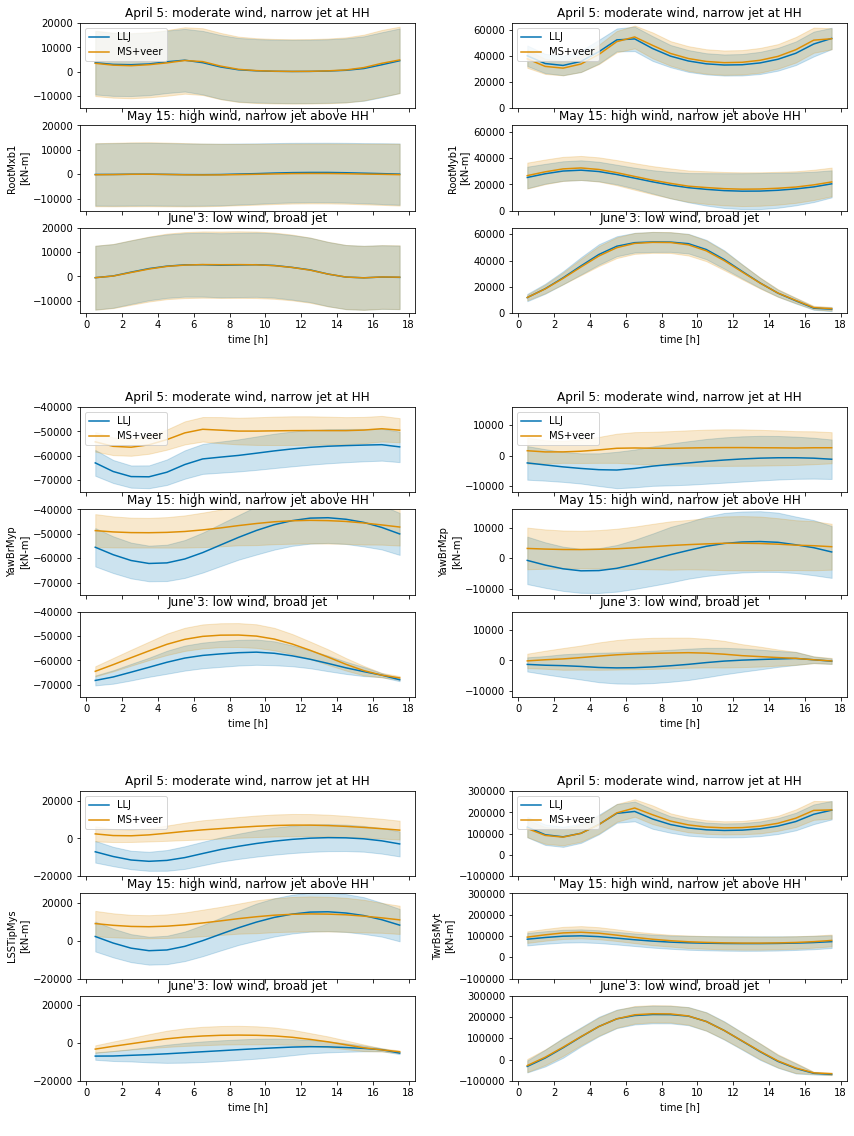

In [45]:
fig = plt.figure(figsize=(12, 16))
subfigs = fig.subfigures(3, 2)

qtys = ['RootMxb1','RootMyb1','YawBrMyp','YawBrMzp','LSSTipMys','TwrBsMyt']
ylims = [[-15000, 20000], [0, 65000],[-75000, -40000],[-12000,16000],[-20000,25000],[-100000,300000]]
for (i, (qty, fig)) in enumerate(zip(qtys, subfigs.flat)):
    plot_comparison(fig,qty,qty,ylims[i])
plt.savefig('figures/fig4_all_timeseries.pdf',bbox_inches='tight')

## Correlations with jet characteristics?

In [46]:
def plot_correlation(channel1,channel2):
    """Plot correlation of two channels for all 3 case days
    """
    fig,axs = plt.subplots(nrows=1, figsize=(8,6))
    for (date,desc) in dates.items():
        for cond in inflows:
            ds1 = stats[f'{channel1}'].sel(date=date,cond=cond).data.flatten()
            ds2 = stats[f'{channel2}'].sel(date=date,cond=cond).data.flatten()
            if cond!='LLJ':
                color = line.get_color()
                line, = axs.plot(ds1, ds2, label=date+'_'+cond, marker='.', fillstyle='full', linestyle='none', color=color, ms=10)
            else:
                line, = axs.plot(ds1, ds2, label=date+'_'+cond, marker='^', fillstyle='none', linestyle='none', ms=8)
    axs.legend(loc='upper left',bbox_to_anchor=(1,1))
    axs.set_xlabel(f'{channel1}\n[{ds1.attrs["units"]}]')
    axs.set_ylabel(f'{channel2}\n[{ds2.attrs["units"]}]')
    fig.tight_layout()
    return fig,axs

In [112]:
def plot_correlation(axs,channel1,channel2):
    """Plot correlation of two channels for all 3 case days
    """
    for (date,desc) in dates.items():
        for cond in inflows:
            ds1 = stats[f'{channel1}'].sel(date=date,cond=cond).data.flatten()
            ds2 = stats[f'{channel2}'].sel(date=date,cond=cond).data.flatten()
            ds3 = stats['z_max'].sel(date=date).data.flatten()
            hh = 150.0
            if cond!='LLJ':
                color = line.get_color()
                line, = axs.plot(ds1, ds2, label=date+' MS', marker='.', fillstyle='full', linestyle='none', color=color, ms=8)
            else:
                line, = axs.plot(ds1[ds3 > hh], ds2[ds3 > hh], label='_', marker='^', fillstyle='none', linestyle='none', ms=6)
                color = line.get_color()
                line, = axs.plot(ds1[ds3 <= hh], ds2[ds3 <= hh], label='_', marker='v', fillstyle='none', linestyle='none', ms=6,color=color)
    axs.set_xlabel(f'{channel1}\n[{stats[channel1].attrs["units"]}]')
    axs.set_ylabel(f'{channel2}\n[{stats[channel2].attrs["units"]}]')
    axs.set_xlim([0.0, 25.0])

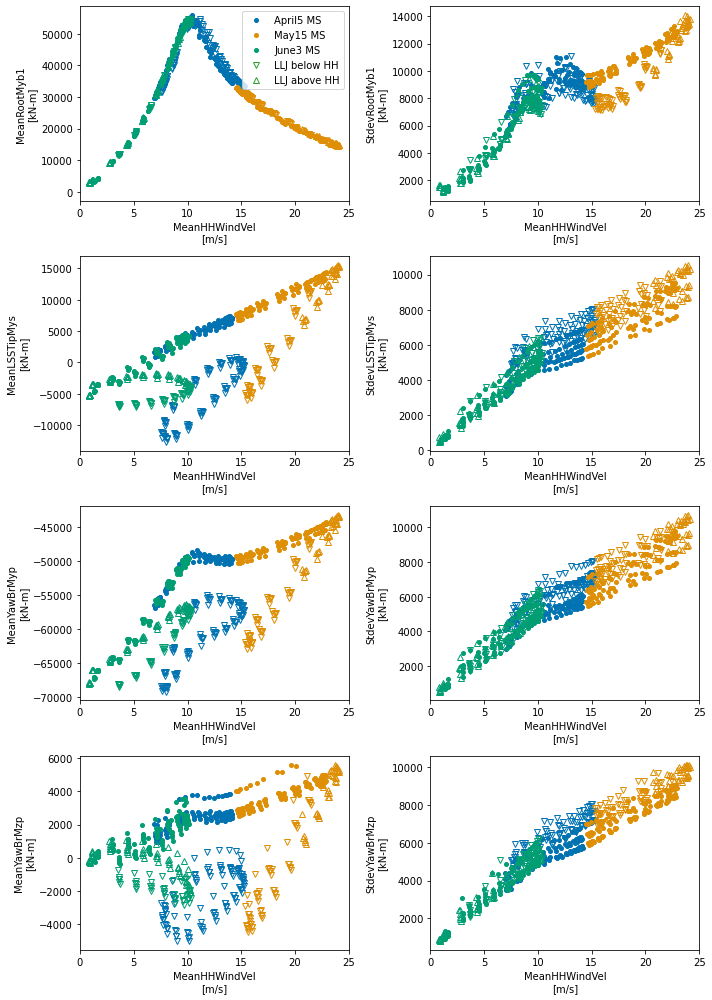

In [114]:
fields = ['RootMyb1','LSSTipMys','YawBrMyp','YawBrMzp']
(fig, axs) = plt.subplots(4, 2, figsize=(10,14))
for (j,field) in enumerate(fields):
    plot_correlation(axs[j][0], 'MeanHHWindVel', f'Mean{field}')
    plot_correlation(axs[j][1], 'MeanHHWindVel', f'Stdev{field}')
axs[0][0].plot(-100, -100, label='LLJ below HH', marker='v', fillstyle='none', linestyle='none', ms=6, color='tab:green')
axs[0][0].plot(-100, -100, label='LLJ above HH', marker='^', fillstyle='none', linestyle='none', ms=6, color='tab:green')
axs[0][0].legend(loc='upper right')
plt.tight_layout()
plt.savefig('figures/fig5_mean_stdev_wrt_HHWS.pdf',bbox_inches='tight')

In [ ]:
def compute_envelope(cond,channel1,channel2, bins):
    ds1 = stats[f'{channel1}'].sel(cond=cond).data
    ds2a = stats[f'Max{channel2}'].sel(cond=cond).data 
    ds2b = stats[f'Min{channel2}'].sel(cond=cond).data
    dbin = bins[1] - bins[0]
    mins = np.zeros_like(bins)
    maxs = np.zeros_like(bins)
    envelope = np.zeros_like(bins)
    for (j, bin) in enumerate(bins):
        mins[j] = np.min(ds2b[np.logical_and(ds1 >= bin, ds1 < bin + dbin)])
        maxs[j] = np.max(ds2a[np.logical_and(ds1 >= bin, ds1 < bin + dbin)])
    envelope = maxs - mins
    return (mins, maxs, envelope)

In [66]:
def plot_envelope_width(ax,channel1,channel2,bins=np.linspace(1.0,22.0,21)):
    """Plot correlation of two channels for all 3 case days
    """
    for cond in inflows:
        (mins, maxs, envelope) = compute_envelope(cond, channel1, channel2, bins)
        line, = ax.plot(bins, envelope, label=f'{cond}')
        color = line.get_color()
    #ax.set_xlabel('MeanWind3VelX' + f'[{stats["MeanWind3VelX"].attrs["units"]}]')
    ax.set_ylabel(f'Envelope of {channel2}\n[{stats[f"Mean{channel2}"].attrs["units"]}]')

In [68]:
def plot_envelope(ax,channel1,channel2,bins=np.linspace(1.0,22.0,21)):
    """Plot correlation of two channels for all 3 case days
    """
    for cond in inflows:
        (mins, maxs, envelope) = compute_envelope(cond, channel1, channel2, bins)
        ax.fill_between(bins, mins, maxs, alpha=0.4, label=f'{cond}')
    #ax.set_xlabel('MeanWind3VelX' + f'[{stats["MeanWind3VelX"].attrs["units"]}]')
    ax.set_ylabel(f'Envelope of {channel2}\n[{stats[f"Mean{channel2}"].attrs["units"]}]')

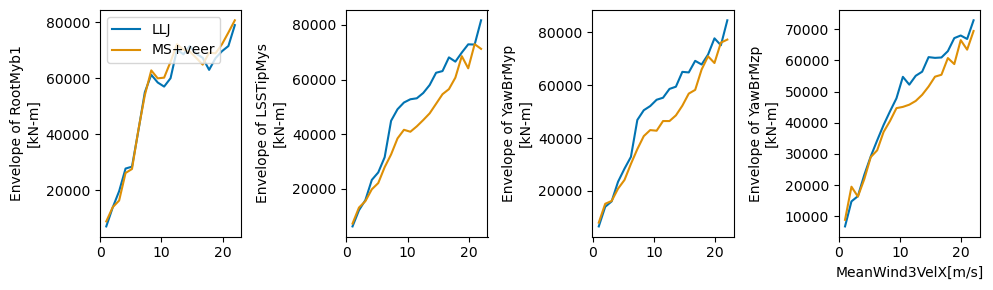

In [69]:
fields = ['RootMyb1','LSSTipMys','YawBrMyp','YawBrMzp']
(fig, axs) = plt.subplots(1, 4, sharex=True, figsize=(10,3))
for (j,field) in enumerate(fields):
    plot_envelope_width(axs[j], 'MeanWind3VelX', field)

axs[0].legend(loc='upper left')
axs[-1].set_xlabel('MeanWind3VelX' + f'[{stats["MeanWind3VelX"].attrs["units"]}]')
plt.tight_layout()
plt.savefig('figures/fig6a_envelopes.pdf',bbox_inches='tight')

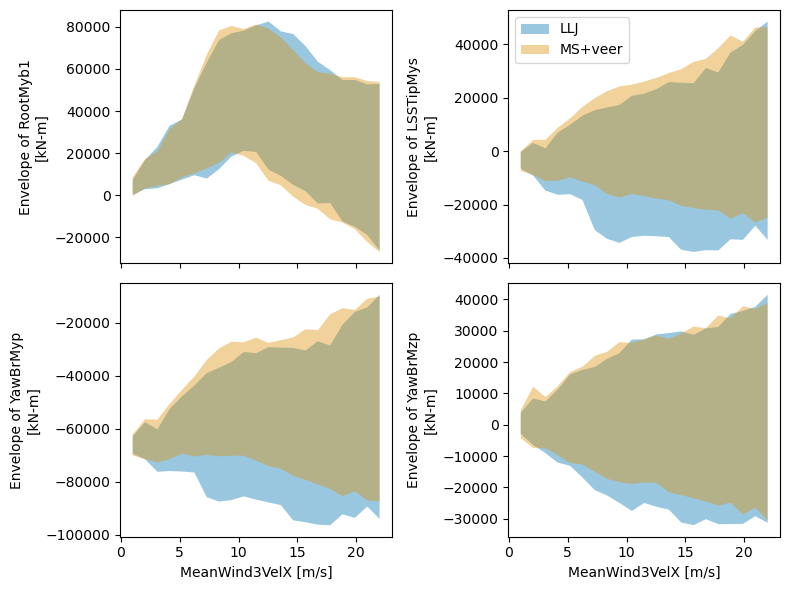

In [70]:
fields = ['RootMyb1','LSSTipMys','YawBrMyp','YawBrMzp']
(fig, axs) = plt.subplots(2, 2, sharex=True, figsize=(8,6))
for (j,field) in enumerate(fields):
    plot_envelope(axs[j//2][j%2], 'MeanWind3VelX', field)
    #plot_envelope_width(axs[j], 'MeanWind3VelX', field)
axs[0][1].legend(loc='upper left')
axs[1][0].set_xlabel('MeanWind3VelX' + f' [{stats["MeanWind3VelX"].attrs["units"]}]')
axs[1][1].set_xlabel('MeanWind3VelX' + f' [{stats["MeanWind3VelX"].attrs["units"]}]')
plt.tight_layout()
plt.savefig('figures/fig6b_envelopes.pdf',bbox_inches='tight')

In [ ]:
stats['totalWindX'] = (stats['MeanWind1VelX'] + stats['MeanWind2VelX'] + stats['MeanWind4VelX'])/3
stats['WindXEnvelope'] = (stats['MeanWind3VelX']) / stats['totalWindX']

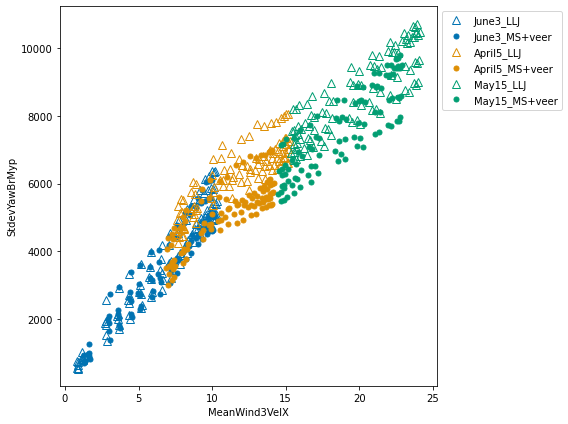

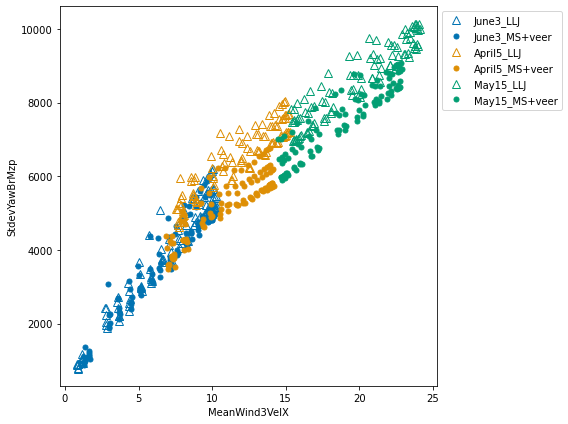

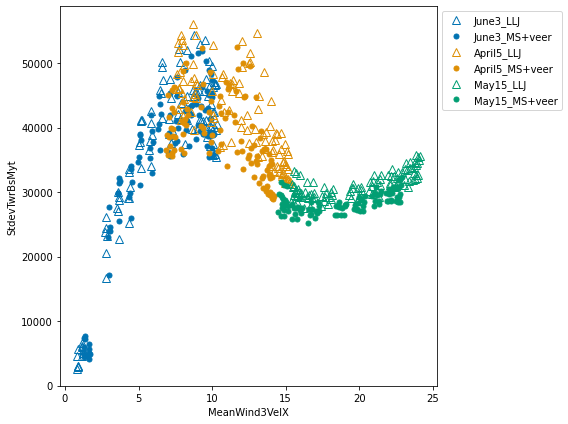

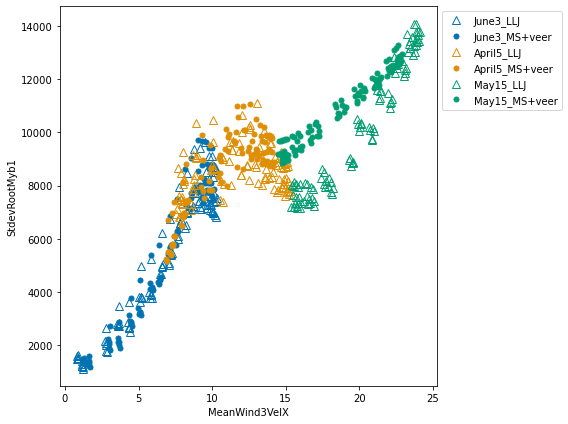

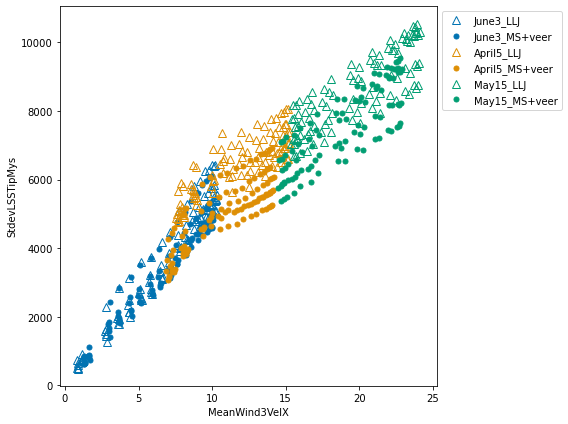

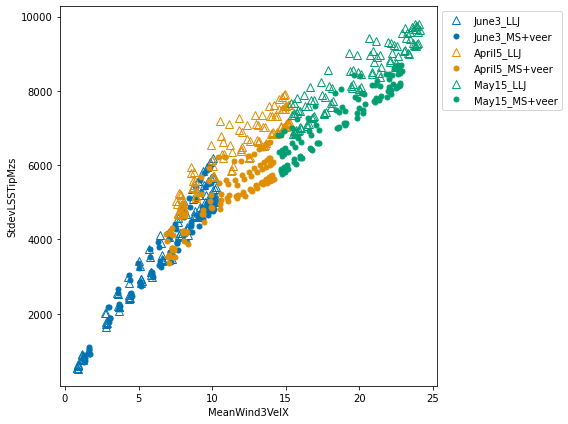

In [ ]:
fields = ['YawBrMyp', 'YawBrMzp','TwrBsMyt','RootMyb1', 'LSSTipMys', 'LSSTipMzs']
for field in fields:
    ff = 'Stdev'+field
    plot_correlation('MeanWind3VelX', ff)

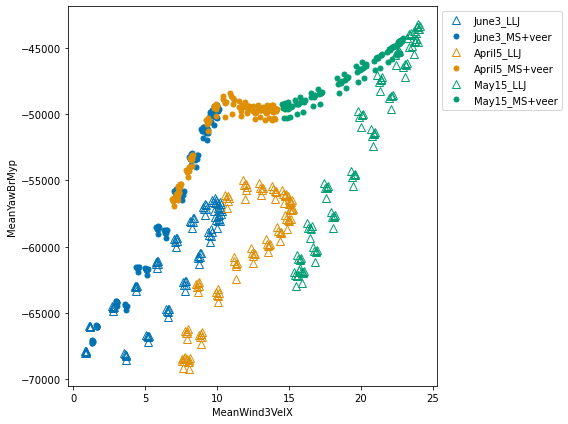

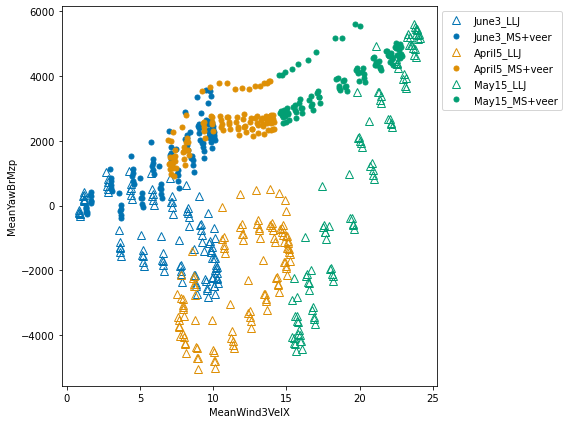

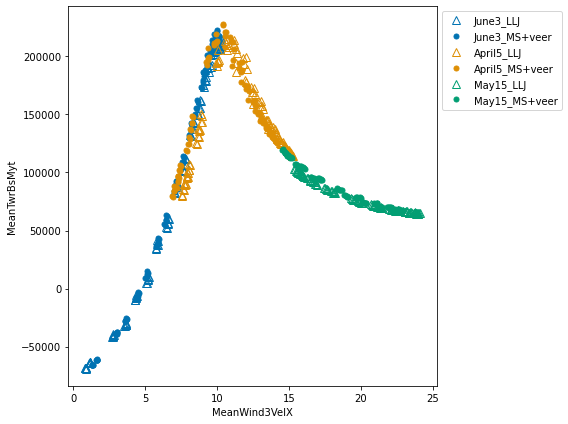

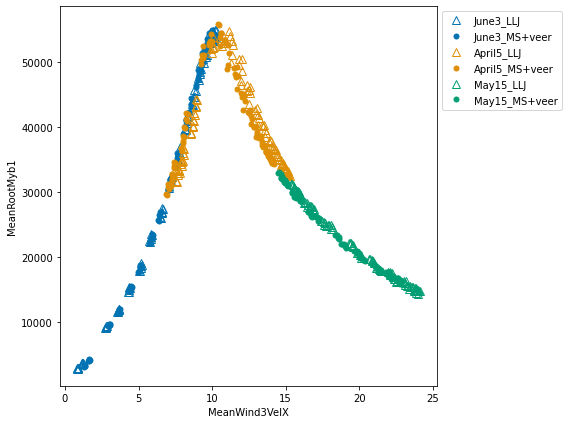

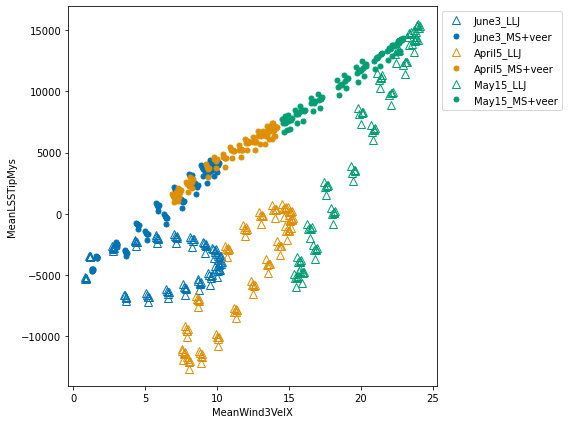

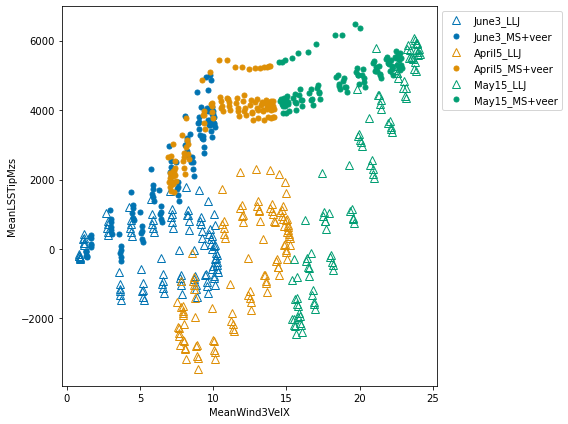

In [ ]:
fields = ['YawBrMyp', 'YawBrMzp','TwrBsMyt','RootMyb1', 'LSSTipMys', 'LSSTipMzs']
for field in fields:
    ff = 'Mean'+field
    plot_correlation('MeanWind3VelX', ff)

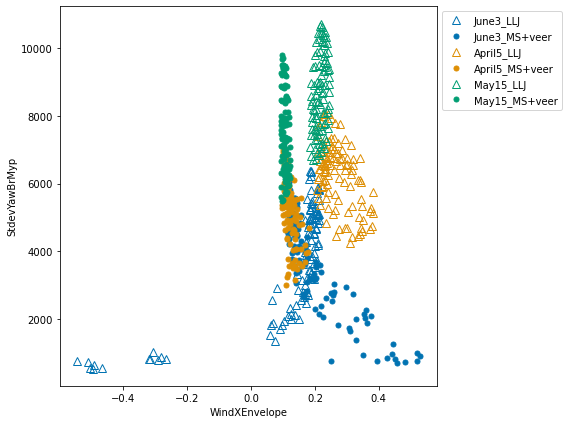

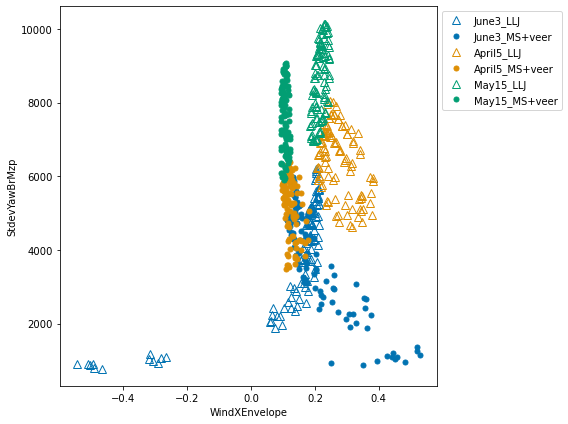

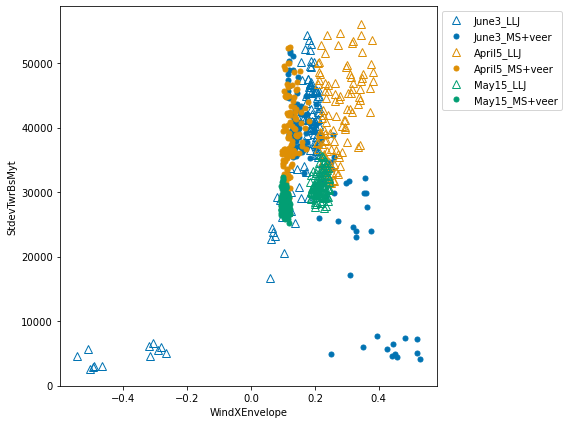

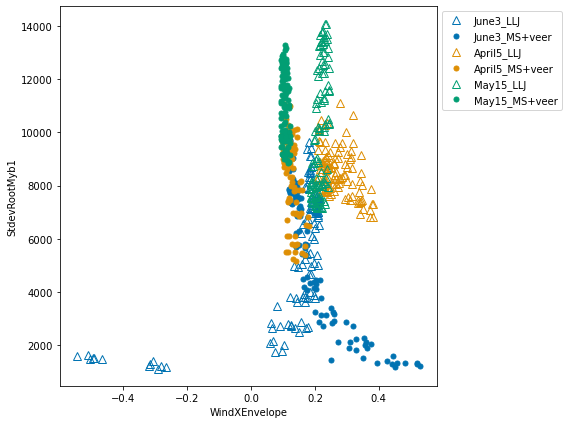

In [ ]:
fields = ['YawBrMyp', 'YawBrMzp','TwrBsMyt','RootMyb1']
for field in fields:
    ff = 'Stdev'+field
    plot_correlation('WindXEnvelope', ff)


In [ ]:
fields = ['YawBrMyp', 'YawBrMzp','TwrBsMyt','RootMyb1']
for field in fields:
    stats['ratio' + field] = stats['Stdev'+field] / np.abs(stats['Mean'+field])

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='MeanWind3VelX', ylabel='ratioYawBrMzp'>)

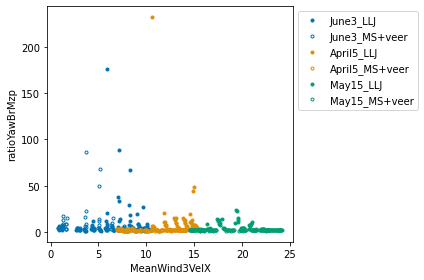

In [ ]:
plot_correlation('MeanWind3VelX', 'ratioYawBrMzp')